## Red convolucional Tensorflow
- En este notebook se definen y regularizan arquitecturas de redes convolucionales

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## 1.- Pipeline
- El dataset cifar10 consiste de imágenes de resolución $32 \times 32$. Al ser imágenes RGB se tienen 3 canales.

In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Convert y_train and y_test to one hot 
y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=num_classes, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    y_test, num_classes=num_classes, dtype='float32'
)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


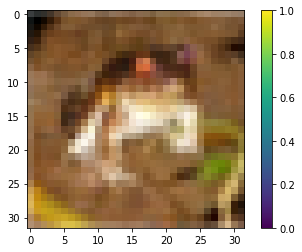

In [3]:
print(y_train[0])

plt.imshow(x_train[0, :, :, :])
plt.colorbar()
plt.show()

In [4]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 10))

In [5]:
ds_len = len(x_train)
batch_size = 64

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((x_train, y_train))
train_ds = train_ds.shuffle(len(train_ds)).batch(batch_size)

test_ds = tf.data.Dataset.zip((x_test, y_test))
test_ds = test_ds.batch(batch_size)

test_batch = next(iter(train_ds))
test_batch[0].shape, test_batch[1].shape

(TensorShape([64, 32, 32, 3]), TensorShape([64, 10]))

## 2.- Capas
- Definir una clase Conv2D(tf.keras.layers.Layer) y su método build() 

In [7]:
class Conv2D(layers.Layer):
    def __init__(self, filters, kernel_size, 
                 strides=1, padding='VALID'):
        super(Conv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=[self.kernel_size, 
                                             self.kernel_size,
                                             input_shape[-1],
                                             self.filters])

    def call(self, inputs):
        x = tf.nn.conv2d(inputs, self.kernel, 
                         strides=[1, self.strides, self.strides, 1],
                         padding=self.padding)
        return x


layer = Conv2D(5, 2, padding='SAME')
layer(tf.ones([1, 32, 32, 3]))

<tf.Tensor: shape=(1, 32, 32, 5), dtype=float32, numpy=
array([[[[-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         [-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         [-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         ...,
         [-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         [-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         [-0.834822  ,  0.827458  , -0.08334106, -0.8090108 ,
           0.42283142]],

        [[-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         [-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         [-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         ...,
         [-1.5551076 ,  0.48654872,  0.05096656, -0.53206563,
           0.16064602],
         [-1.5551076 ,  0.48654872,  0.05096656, -0.53

- Prueba capa de convoluciones

In [8]:
test_layer = Conv2D(
    filters=5,
    kernel_size=3,
    strides = 1,
    padding='SAME'
    )

test_output = test_layer(test_batch[0])
test_output.shape

TensorShape([64, 32, 32, 5])

In [9]:
test_layer2 = Conv2D(
    filters=10,
    kernel_size=3,
    strides = 2,
    padding='VALID'
    )

In [10]:
test_output2 = test_layer2(test_output)
test_output2.shape

TensorShape([64, 15, 15, 10])

In [11]:
tf.keras.layers.Flatten()(test_output2).shape

TensorShape([64, 2250])

In [12]:
import tensorflow as tf

- Definir una clase Linear(tf.keras.layers.Layer) y su método build() 

In [13]:
class Linear(layers.Layer):
    def __init__(self, num_outputs, activation=None):
        super(Linear, self).__init__()
        self.num_outputs = num_outputs
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=[int(input_shape[-1]), 
                                             self.num_outputs])
        self.bias = self.add_weight("bias",
                                    shape=[1, self.num_outputs])

    def call(self, inputs):
        x = tf.matmul(inputs, self.kernel) + self.bias

        if self.activation == 'relu':
            x = tf.nn.relu(x)
        elif self.activation == 'sigmoid':
            x = tf.math.sigmoid(x)

        return x


layer = Linear(10, 'relu')
layer(tf.ones([1, 784]))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.       , 0.       , 0.       , 0.       , 0.       , 1.9876688,
        0.       , 0.       , 1.0542314, 3.166893 ]], dtype=float32)>

## 3.- Entrenamientos

In [14]:
epochs = 10
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

- Una sola capa convolucional

In [15]:
model = tf.keras.Sequential([
    Conv2D(filters=10, kernel_size=3,
           strides = 2, padding='VALID'),
    layers.Flatten(),
    Linear(10),
])

optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss=loss_fn,
              optimizer=optimizer)

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs, verbose=1)

Epoch 1/10
782/782 [==============================] - 2s 1ms/step - loss: 2.0411 - val_loss: 1.9225
Epoch 2/10
782/782 [==============================] - 1s 1ms/step - loss: 1.8855 - val_loss: 1.8555
Epoch 3/10
782/782 [==============================] - 1s 1ms/step - loss: 1.8378 - val_loss: 1.8195
Epoch 4/10
782/782 [==============================] - 1s 1ms/step - loss: 1.8100 - val_loss: 1.8017
Epoch 5/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7931 - val_loss: 1.7864
Epoch 6/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7803 - val_loss: 1.7788
Epoch 7/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7699 - val_loss: 1.7712
Epoch 8/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7609 - val_loss: 1.7623
Epoch 9/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7558 - val_loss: 1.7583
Epoch 10/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7488 - val_loss: 1.7551

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 15, 15, 10)        270       
                                                                 
 flatten_1 (Flatten)         (None, 2250)              0         
                                                                 
 linear_1 (Linear)           (None, 10)                22510     
                                                                 
Total params: 22,780
Trainable params: 22,780
Non-trainable params: 0
_________________________________________________________________


- Agregando más capas convolucionales, activaciones y normalizando por lotes 

In [17]:
model = tf.keras.Sequential([
    Conv2D(filters=16, kernel_size=3,
                  strides = 2, padding='VALID'),
    layers.BatchNormalization(),
    layers.ReLU(),
    Conv2D(filters=32, kernel_size=3,
                  strides=2, padding='VALID'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Flatten(),
    Linear(256, activation='relu'),
    Linear(10),
])

optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss=loss_fn,
              optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs, verbose=1)

Epoch 1/10
782/782 [==============================] - 2s 2ms/step - loss: 1.6577 - accuracy: 0.4091 - val_loss: 1.4377 - val_accuracy: 0.4848
Epoch 2/10
782/782 [==============================] - 1s 2ms/step - loss: 1.3363 - accuracy: 0.5251 - val_loss: 1.3165 - val_accuracy: 0.5293
Epoch 3/10
782/782 [==============================] - 1s 2ms/step - loss: 1.2065 - accuracy: 0.5727 - val_loss: 1.2358 - val_accuracy: 0.5601
Epoch 4/10
782/782 [==============================] - 2s 2ms/step - loss: 1.1170 - accuracy: 0.6101 - val_loss: 1.1969 - val_accuracy: 0.5747
Epoch 5/10
782/782 [==============================] - 1s 2ms/step - loss: 1.0454 - accuracy: 0.6379 - val_loss: 1.1663 - val_accuracy: 0.5879
Epoch 6/10
782/782 [==============================] - 1s 2ms/step - loss: 0.9820 - accuracy: 0.6619 - val_loss: 1.1433 - val_accuracy: 0.5925
Epoch 7/10
782/782 [==============================] - 2s 2ms/step - loss: 0.9293 - accuracy: 0.6803 - val_loss: 1.1378 - val_accuracy: 0.5999
Epoch 

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 15, 15, 16)        432       
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 15, 15, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          4608      
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 32)         128       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 7, 7, 32)         

- Regularizando con dropout para evitar sobreajuste

In [19]:
model = tf.keras.Sequential([
    Conv2D(filters=16, kernel_size=3,
                  strides = 2, padding='VALID'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.ReLU(),
    Conv2D(filters=32, kernel_size=3,
                  strides=2, padding='VALID'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.Flatten(),
    Linear(256, activation='relu'),
    Linear(10),
])

optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss=loss_fn,
              optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs, verbose=1)

Epoch 1/10
782/782 [==============================] - 2s 2ms/step - loss: 1.8431 - accuracy: 0.3368 - val_loss: 1.5888 - val_accuracy: 0.4308
Epoch 2/10
782/782 [==============================] - 2s 2ms/step - loss: 1.5630 - accuracy: 0.4388 - val_loss: 1.4211 - val_accuracy: 0.4893
Epoch 3/10
782/782 [==============================] - 2s 2ms/step - loss: 1.4500 - accuracy: 0.4821 - val_loss: 1.3406 - val_accuracy: 0.5210
Epoch 4/10
782/782 [==============================] - 2s 2ms/step - loss: 1.3594 - accuracy: 0.5156 - val_loss: 1.2750 - val_accuracy: 0.5486
Epoch 5/10
782/782 [==============================] - 2s 2ms/step - loss: 1.2908 - accuracy: 0.5379 - val_loss: 1.2300 - val_accuracy: 0.5615
Epoch 6/10
782/782 [==============================] - 2s 2ms/step - loss: 1.2397 - accuracy: 0.5616 - val_loss: 1.2051 - val_accuracy: 0.5700
Epoch 7/10
782/782 [==============================] - 2s 2ms/step - loss: 1.1970 - accuracy: 0.5742 - val_loss: 1.2198 - val_accuracy: 0.5613
Epoch 

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 15, 15, 16)        432       
                                                                 
 batch_normalization_2 (Batc  (None, 15, 15, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 15, 15, 16)        0         
                                                                 
 re_lu_2 (ReLU)              (None, 15, 15, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          4608      
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 32)         128       
 hNormalization)                                      

## Ejercicio

- Modificar la arquitectura para mejorar los resultados de evaluación en el conjunto de prueba
- Mejorar el entrenamiento